## Domain 3 - base run

* 36 hrs
* Forced with 24 hr gaussian wind event, alongshore, upwelling favourable
* winter stratification
* tangential vel at boundaries set to zero
* no sponge

In [1]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec

import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [26]:
def get_snapshot(state_file, tt, zz):
    with Dataset(state_file, 'r') as nbl:
        T = nbl.variables['Temp'][tt,zz,:,:]
        U = nbl.variables['U'][tt,zz,:,:]
        V = nbl.variables['V'][tt,zz,:,:]
    return(T,U,V)

def get_ssh(state_file, tt):
    with Dataset(state_file, 'r') as nbl:
        eta = nbl.variables['Eta'][tt,:,:]
    return(eta)

def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v

def plot_level_vars(state_file,time_indexes,zz=0):
    with Dataset(state_file, 'r') as nbl:
        time = nbl.variables['T'][:]

    for tt, ti in zip(time_indexes, time[time_indexes]):
        T,U,V = get_snapshot(state_file, tt, zz)
        eta = get_ssh(state_file, tt)

        fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(16,4.5), sharey=True)
        ax0.set_facecolor('tan')
        ax1.set_facecolor('tan')
        ax2.set_facecolor('tan')
        ax3.set_facecolor('tan')

        pc = ax0.contourf(lon,lat, np.ma.masked_array(eta*1E2,mask=mask[zz,:,:]),20,
                          cmap=cmo.cm.delta, vmin=-2, vmax=2)
        cb = plt.colorbar(pc, ax=ax0)

        pc2 = ax1.contourf(lon,lat, np.ma.masked_array(T,mask=mask[zz,:,:]),20,
                           cmap=cmo.cm.thermal, vmin=15, vmax=16)
        cb2 = plt.colorbar(pc2, ax=ax1)

        pc3 = ax2.contourf(lon,lat, np.ma.masked_array(U[:,:-1]*1E2,mask=mask[zz,:,:]),20,
                           cmap=cmo.cm.balance, vmin=-20, vmax=20)
        cb3 = plt.colorbar(pc3, ax=ax2)

        pc4 = ax3.contourf(lon,lat, np.ma.masked_array(V[:-1,:]*1E2,mask=mask[zz,:,:]),20,
                           cmap=cmo.cm.balance, vmin=-20, vmax=20)
        cb4 = plt.colorbar(pc4, ax=ax3)

        ax0.set_xlabel('lon')
        ax1.set_xlabel('lon')
        ax2.set_xlabel('lon')
        ax3.set_xlabel('lon')
        ax0.set_ylabel('lat')

        ax0.set_title('ssh (cm) at %1.1f h'%(ti/3600))
        ax1.set_title('T ($^{\circ}$C) at %1.1f h'%(ti/3600))
        ax2.set_title('U (cm s$^{-1}$) at %1.1f h'%(ti/3600))
        ax3.set_title('V (cm s$^{-1}$) at %1.1f h'%(ti/3600))
        ax0.set_aspect(1)
        ax1.set_aspect(1)
        ax2.set_aspect(1)
        ax3.set_aspect(1)
        

def plot_merid_CS(statefile,tt,lon_ind,var, cb_label, Tcmap, Tmin, Tmax, mask):
    '''tt: time index
       lon_ind: longitude index
       var: str, variable name to plot
       cb_label: str, colorbar label
       Tcmap: cmo colormap
       Tmin: float, lower limit colormap
       Tmax: float, upper limit colormap
       mask: 3D array, land mask for variable var.
       '''
    with Dataset(state_file, 'r') as nbl:
        T = nbl.variables[var][tt,:,:,lon_ind]
        mask_exp = np.expand_dims(mask[:,:,lon_ind],0) + np.zeros_like(T)
        T1 = np.ma.masked_array(T,mask=mask_exp)
        time = nbl.variables['T'][:]

    # meridional cross-section
    fig = plt.figure(figsize=(5,5))
    gs = GridSpec(1,1, width_ratios=[1], wspace=0.02)
    ax1 = fig.add_subplot(gs[0])

    ax1.set_facecolor('tan')

    pc = ax1.pcolormesh(lat,Z,T1[:,:len(lat)],cmap=Tcmap, vmin=Tmin, vmax=Tmax)
    cn = ax1.contour(lat,Z,T1[:,:len(lat)],levels=np.linspace(Tmin,Tmax,15), colors='k')
   
    norm = mpl.colors.Normalize(vmin=Tmin, vmax=Tmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=Tcmap),cax=cbar_ax, 
                      orientation='vertical', label=cb_label,
                      format='%1.2f')
    ax1.set_xlabel('Lat')
    ax1.set_ylabel('Depth / m')
    ax1.set_ylim(-200,0)
    ax1.set_xlim(27.8,29.5)
    ax1.text(27.8,5,'%1.1f$^{\circ}$ lon, t=%1.1f hrs' %(lon[lon_ind], time[tt]/3600), fontweight='bold', fontsize=13)
   
def plot_zonal_CS(tt,lat_ind, var, cb_label, Tcmap, Tmin, Tmax, mask):
    '''tt: time index
       lat_ind: latitude index
       var: str, variable name to plot
       cb_label: str, colorbar label
       Tcmap: cmo colormap
       Tmin: float, lower limit colormap
       Tmax: float, upper limit colormap
       mask: 3D array, land mask for variable var.
       '''
    with Dataset(state_file1, 'r') as nbl:
        T = nbl.variables[var][tt,:,lat_ind,:]
        mask_exp = np.expand_dims(mask[:,lat_ind,:],0) + np.zeros_like(T)
        T1 = np.ma.masked_array(T,mask=mask_exp)
        time = nbl.variables['T'][:]
    with Dataset(state_file2, 'r') as nbl:
        T = nbl.variables[var][tt,:,lat_ind,:]
        mask_exp = np.expand_dims(mask[:,lat_ind,:],0) + np.zeros_like(T)
        T2 = np.ma.masked_array(T,mask=mask_exp)
    with Dataset(state_file3, 'r') as nbl:
        T = nbl.variables[var][tt,:,lat_ind,:]
        mask_exp = np.expand_dims(mask[:,lat_ind,:],0) + np.zeros_like(T)
        T3 = np.ma.masked_array(T,mask=mask_exp)

    # meridional cross-section
    fig = plt.figure(figsize=(15,5))
    gs = GridSpec(1,3, width_ratios=[1,1,1], wspace=0.02)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    ax1.set_facecolor('tan')
    ax2.set_facecolor('tan')
    ax3.set_facecolor('tan')

    pc = ax1.pcolormesh(lon,Z,T1[:,:len(lon)],cmap=Tcmap, vmin=Tmin, vmax=Tmax)
    cn = ax1.contour(lon,Z,T1[:,:len(lon)],levels=np.linspace(Tmin,Tmax,15), colors='k')
   
    pc2 = ax2.pcolormesh(lon,Z,T2[:,:len(lon)],cmap=Tcmap, vmin=Tmin, vmax=Tmax)
    cn2 = ax2.contour(lon,Z,T2[:,:len(lon)],levels=np.linspace(Tmin,Tmax,15), colors='k')
   
    pc3 = ax3.pcolormesh(lon,Z,T3[:,:len(lon)],cmap=Tcmap, vmin=Tmin, vmax=Tmax)
    cn3 = ax3.contour(lon,Z,T3[:,:len(lon)],levels=np.linspace(Tmin,Tmax,15), colors='k')
   
    norm = mpl.colors.Normalize(vmin=Tmin, vmax=Tmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=Tcmap),cax=cbar_ax, 
                      orientation='vertical', label=cb_label,
                      format='%1.2f')
    ax1.set_xlabel('Lon')
    ax1.set_ylabel('Depth / m')
    ax2.set_xlabel('Lon')
    ax3.set_xlabel('Lon')
    ax1.set_title('Smagorinsky')
    ax2.set_title(r'Ah=100 m$^2$/s')
    ax3.set_title(r'Ah=10 m$^2$/s')
#    ax1.set_xlim(27,29.5)
#    ax2.set_xlim(27,29.5)
#    ax3.set_xlim(27,29.5)
    ax1.set_ylim(-200,0)
    ax2.set_ylim(-200,0)
    ax3.set_ylim(-200,0)

    ax1.text(243.0,25,'%1.1f$^{\circ}$ lat, t=%1.1f hrs' %(lat[lat_ind], time[tt]/3600), fontweight='bold', fontsize=13)
    ax2.set_yticks([])
    ax3.set_yticks([])

In [83]:
bathy_file1 = '/Users/Karina/Tools/MITgcm/SVB/01_320x454x36_gaussian/03_halfgauss/gridGlob.nc'
state_file1 = '/Users/Karina/Tools/MITgcm/SVB/01_320x454x36_gaussian/03_halfgauss/stateGlob.nc'

### Load bathymetry variables

In [84]:
with Dataset(bathy_file1, 'r') as nbl:
    lat = nbl.variables['Y'][:]
    lon = nbl.variables['X'][:]
    Z = nbl.variables['Z'][:]
    depth = nbl.variables['Depth'][:]
    # centers mask
    hFacC = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacC, 0)
    mask = np.ma.getmask(hfac)
    # U mask
    hFacW = nbl.variables['HFacW'][:]
    hfacW = np.ma.masked_values(hFacW, 0)
    maskU = np.ma.getmask(hfacW)
    # V mask
    hFacS = nbl.variables['HFacS'][:]
    hfacS = np.ma.masked_values(hFacS, 0)
    maskV = np.ma.getmask(hfacS)
    # masked depth
    dep_masked = np.ma.masked_values(depth,0)
    mask_dep = np.ma.getmask(dep_masked)

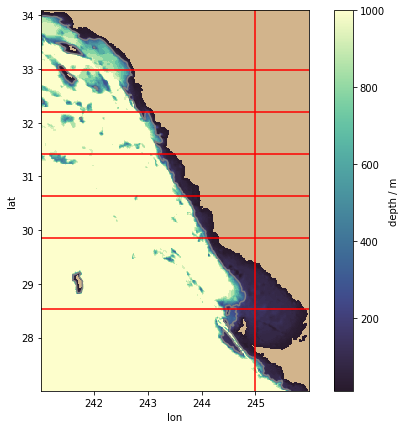

In [100]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.set_facecolor('tan')
pc = ax.pcolormesh(lon,lat,np.ma.masked_array(depth, mask=mask_dep), cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc)
cn2 = ax.contour(lon,lat,depth, colors='0.5', levels=[250])

lon_ind = 255
lat_ind1 = 97
lat_ind2 = 182
# ssh transects
ax.plot(lon[lon_ind]*np.ones_like(lat),lat[:],'r-')
ax.plot(lon[:],lat[lat_ind1]*np.ones_like(lon),'r-')
ax.plot(lon[:],lat[lat_ind2]*np.ones_like(lon),'r-')
ax.plot(lon[:],lat[lat_ind2+50]*np.ones_like(lon),'r-')
ax.plot(lon[:],lat[lat_ind2+100]*np.ones_like(lon),'r-')
ax.plot(lon[:],lat[lat_ind2+150]*np.ones_like(lon),'r-')
ax.plot(lon[:],lat[lat_ind2+200]*np.ones_like(lon),'r-')

# sponge widths
#ax.plot(lon[10]*np.ones_like(lat),lat[:],'-', color='orange')
#ax.plot(lon[:],lat[10]*np.ones_like(lon),'-', color='orange')
#ax.plot(lon[:],lat[-10]*np.ones_like(lon),'-', color='orange')



cb.set_label('depth / m')
ax.set_xlabel('lon')
ax.set_ylabel('lat')

ax.set_aspect(1)

### Surface fields

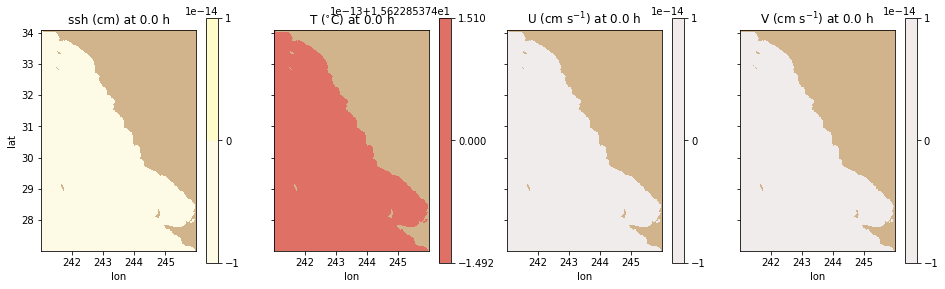

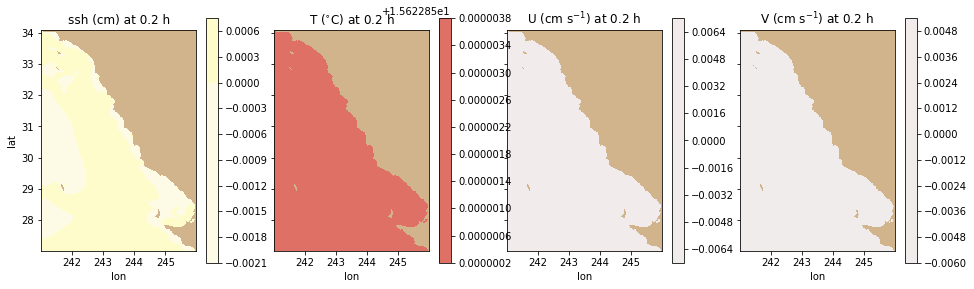

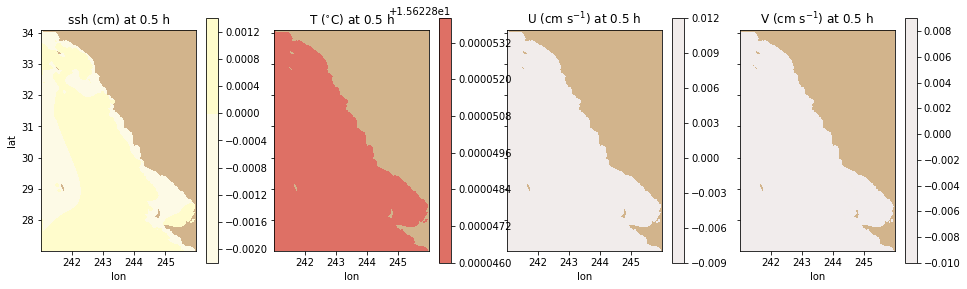

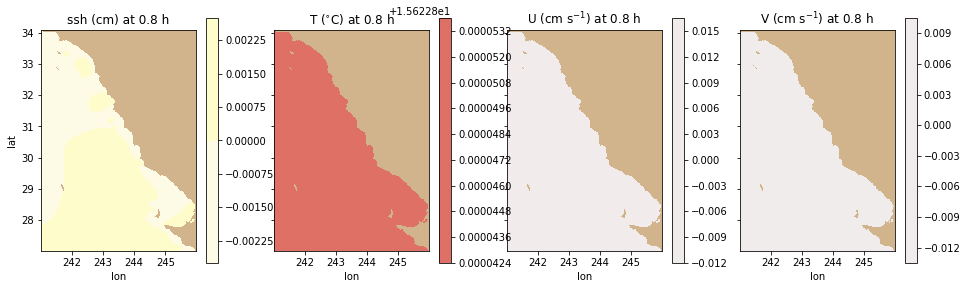

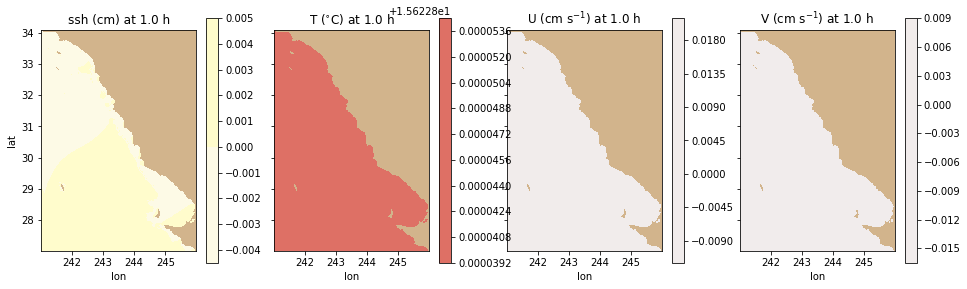

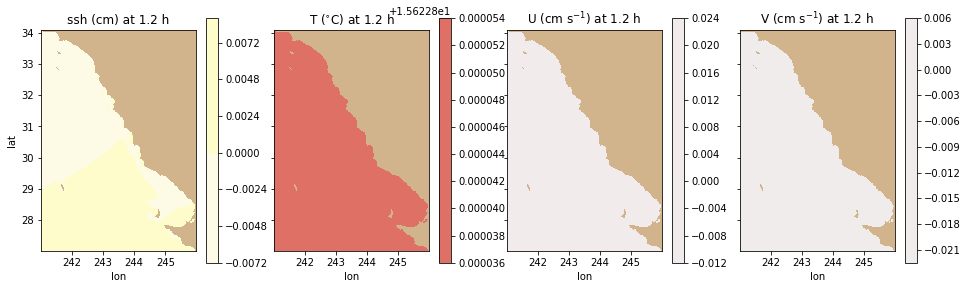

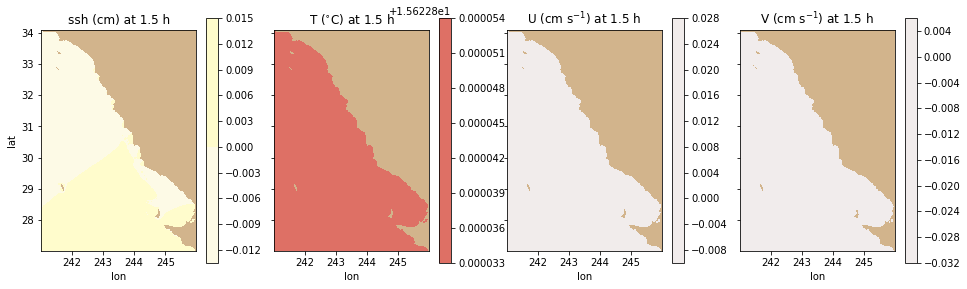

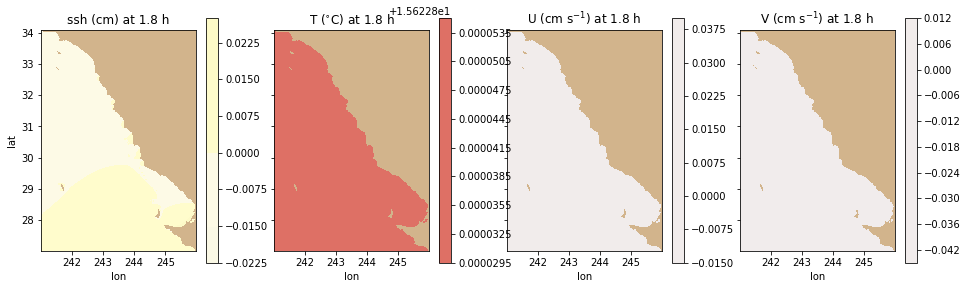

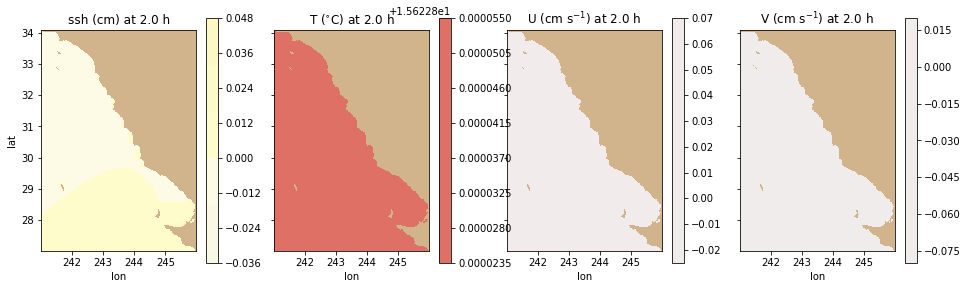

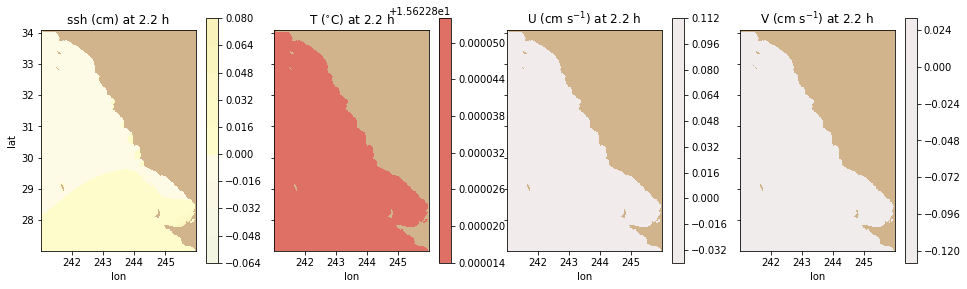

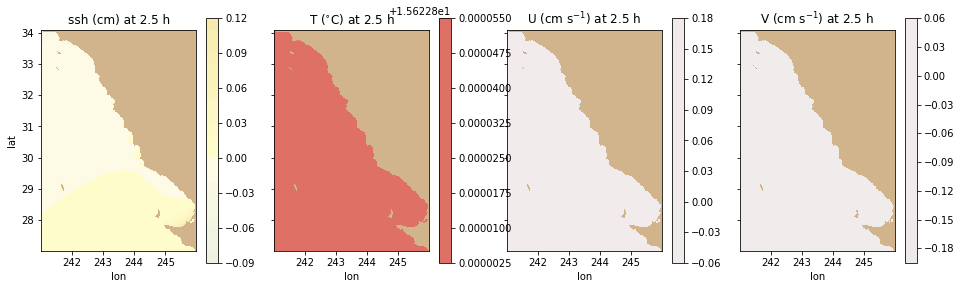

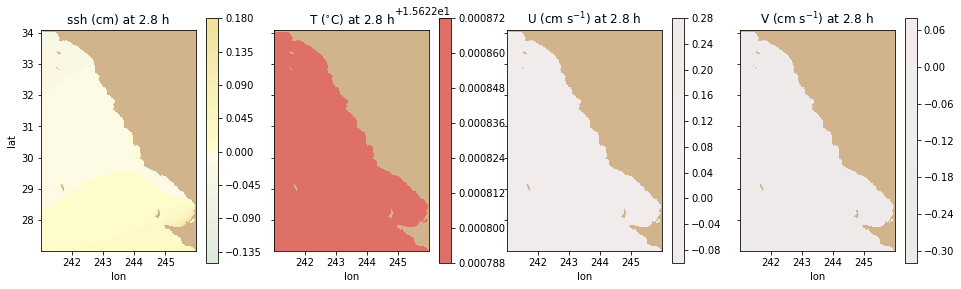

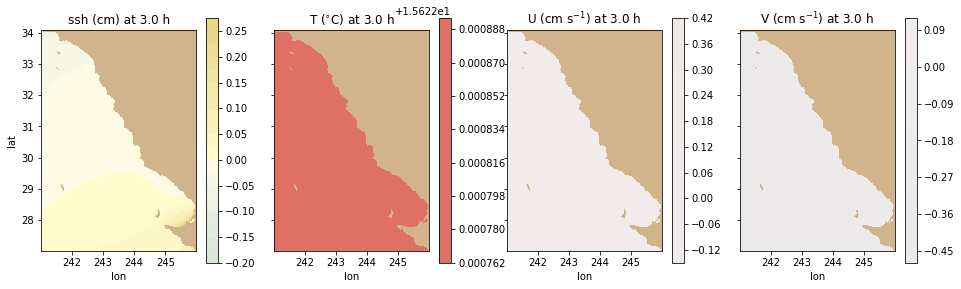

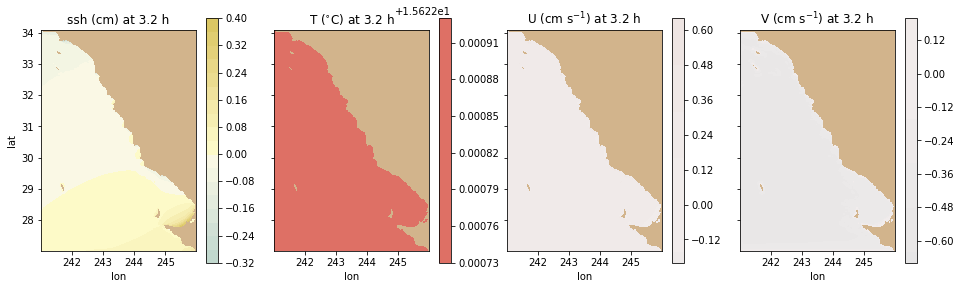

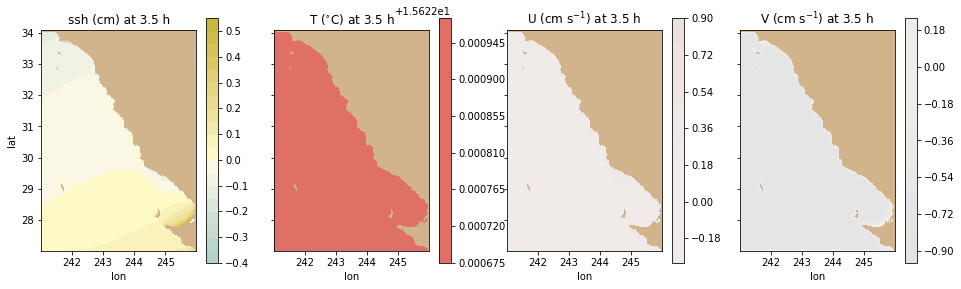

In [103]:
zz=0
state_file= state_file1
time_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] 

plot_level_vars(state_file1, time_indexes, zz=0)

### Cross-sections along red lines in map

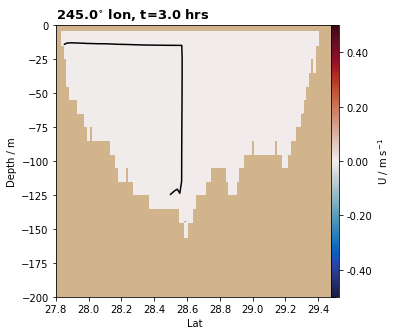

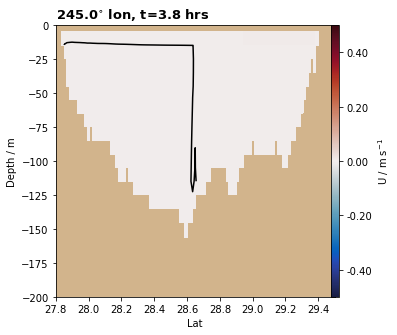

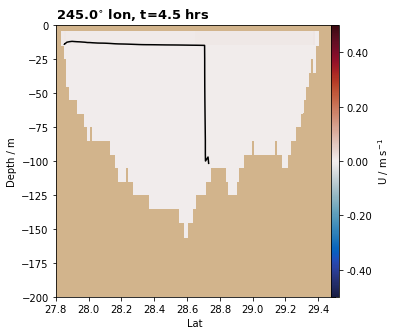

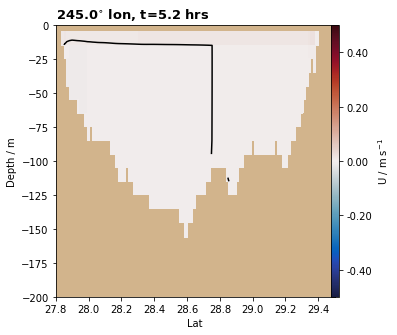

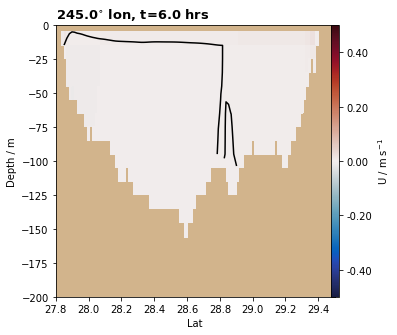

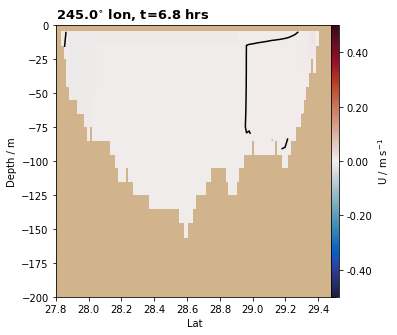

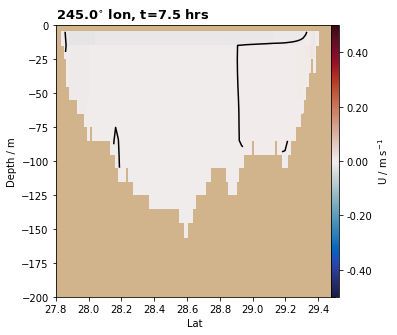

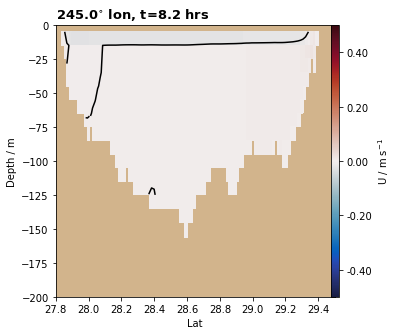

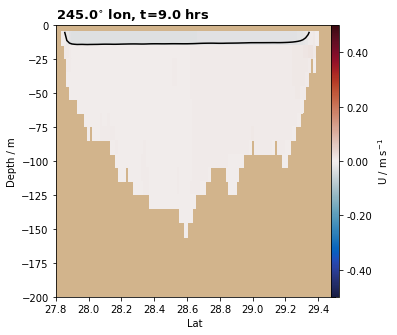

In [89]:
Tmin = -0.5
Tmax = 0.5
Tcmap = cmo.cm.balance

for tt in [12,15,18,21,24,27,30,33,36]:
    plot_merid_CS(state_file1,tt,lon_ind,'U',r'U / m s$^{-1}$',Tcmap, Tmin, Tmax, maskU)

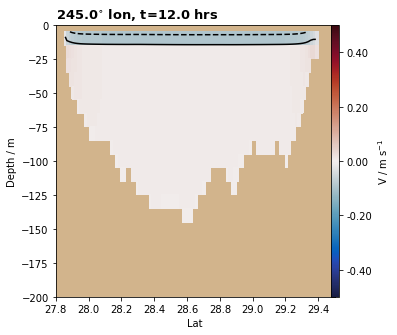

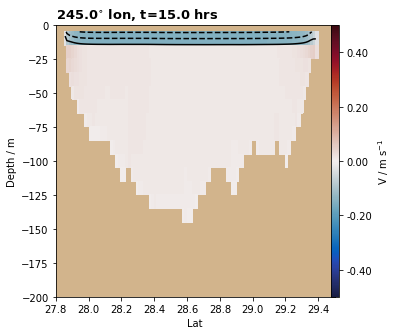

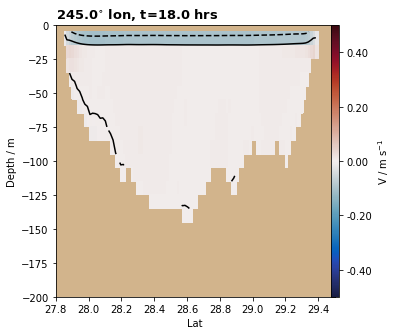

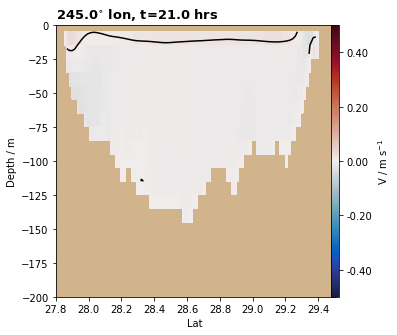

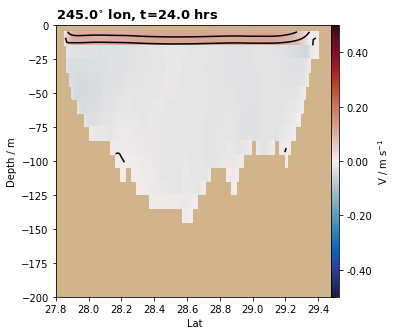

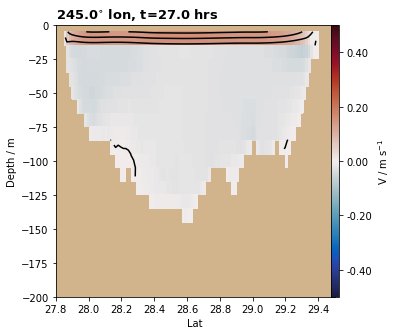

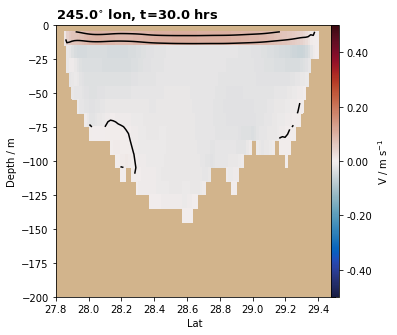

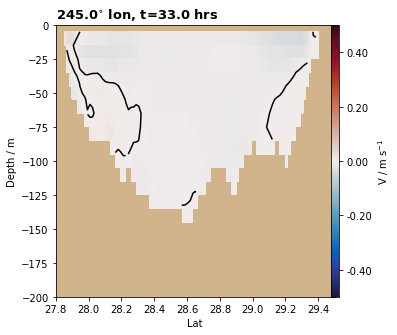

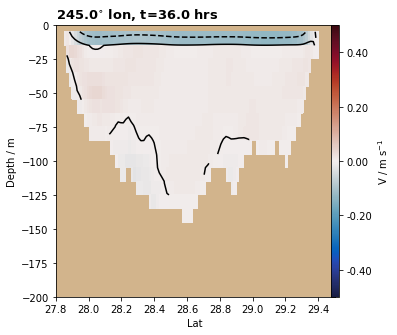

In [77]:
Tmin = -0.5
Tmax = 0.5
Tcmap = cmo.cm.balance

for tt in [12,15,18,21,24,27,30,33,36]:
    plot_merid_CS(state_file1,tt,lon_ind,'V',r'V / m s$^{-1}$',Tcmap, Tmin, Tmax, maskV)

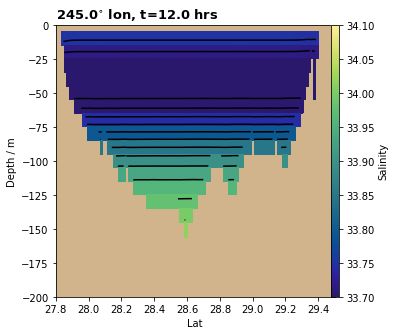

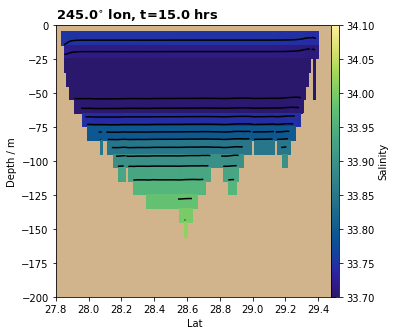

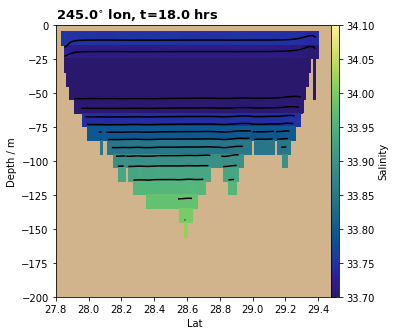

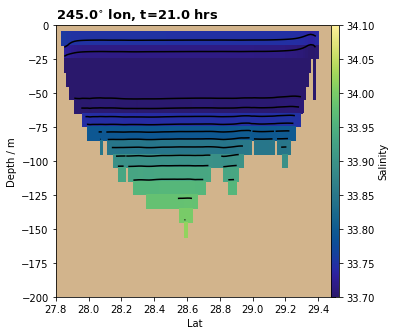

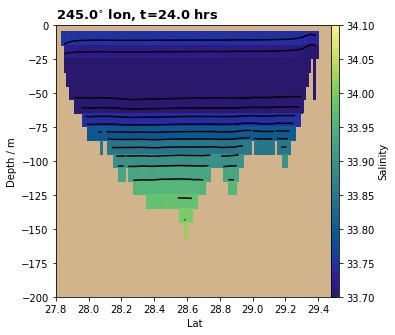

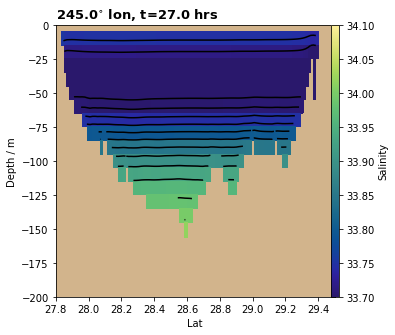

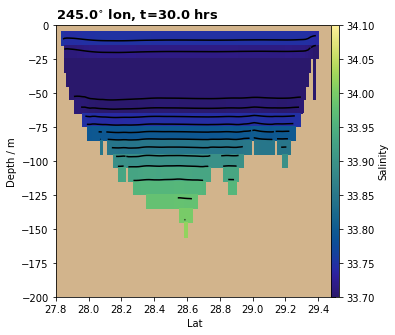

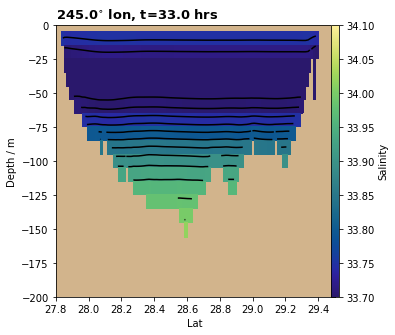

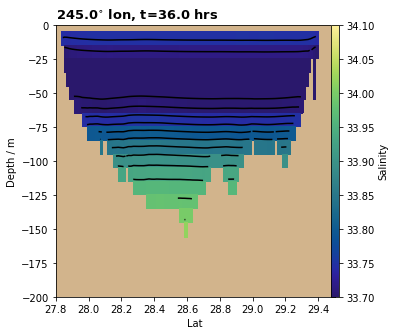

In [78]:
Tmin = 33.7
Tmax = 34.1
Tcmap = cmo.cm.haline

for tt in [12,15,18,21,24,27,30,33,36]:
    plot_merid_CS(state_file1,tt,lon_ind,'S',r'Salinity',Tcmap, Tmin, Tmax, mask)

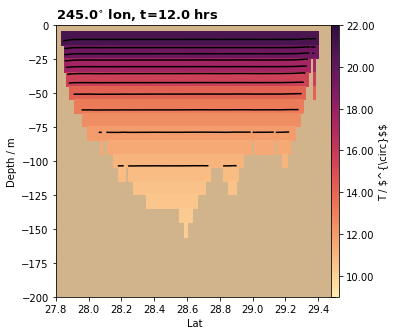

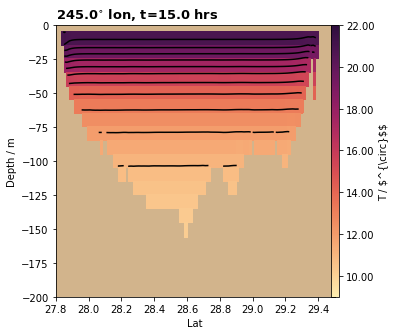

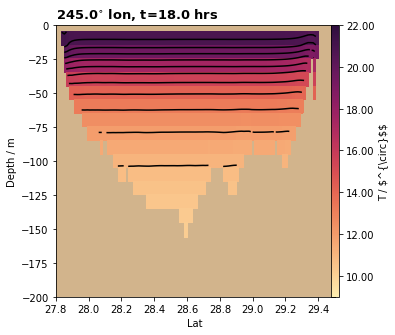

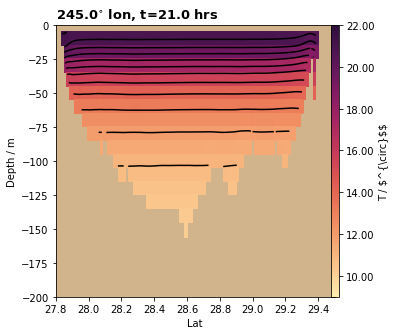

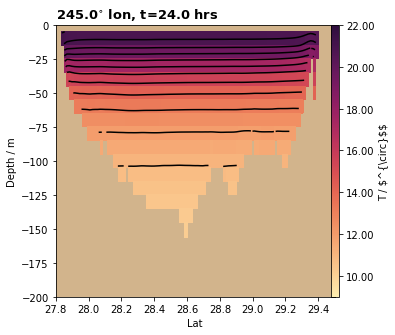

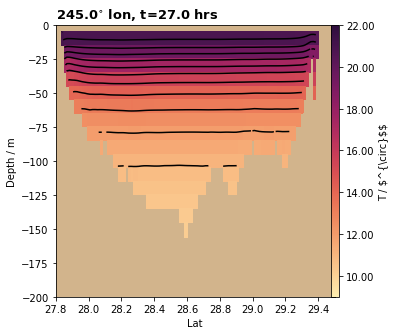

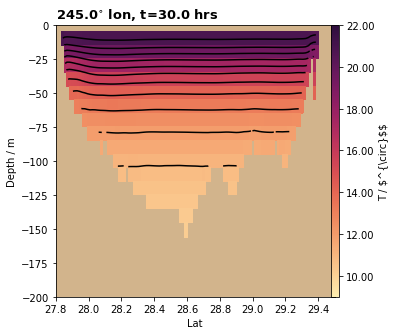

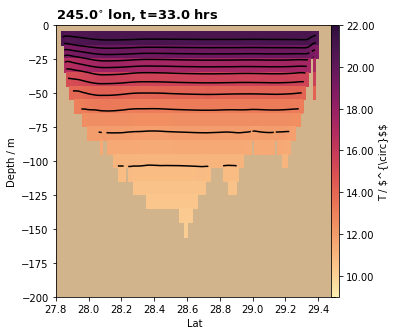

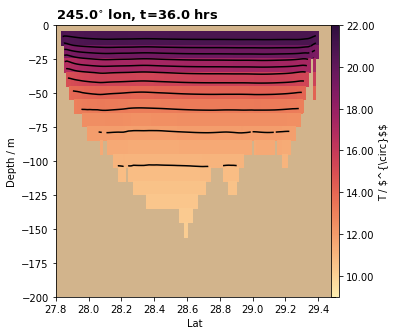

In [81]:
Tmin = 9
Tmax = 22
Tcmap = cmo.cm.matter

for tt in [12,15,18,21,24,27,30,33,36]:
    plot_merid_CS(state_file1,tt,lon_ind,'Temp',r'T / $^{\circ}$$',Tcmap, Tmin, Tmax, mask)

Text(0.5, 0, 'lon')

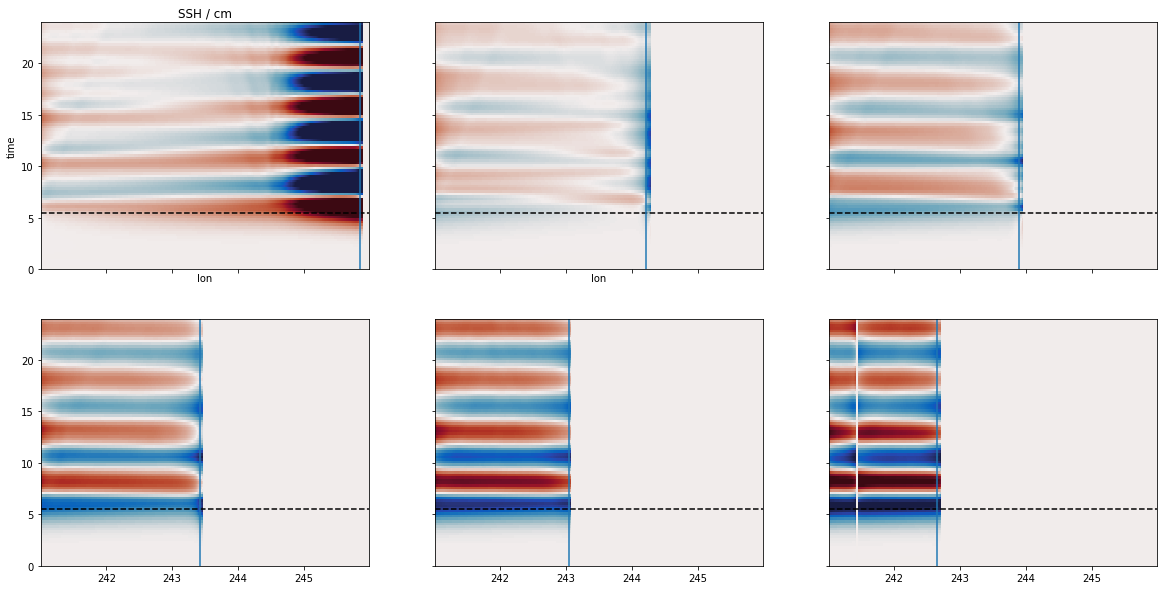

In [124]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,10), sharey=True,sharex=True)
ax1.axhline(5.5, color='k', linestyle='--')
ax2.axhline(5.5, color='k', linestyle='--')
ax3.axhline(5.5, color='k', linestyle='--')
ax4.axhline(5.5, color='k', linestyle='--')
ax5.axhline(5.5, color='k', linestyle='--')
ax6.axhline(5.5, color='k', linestyle='--')

with Dataset(state_file1, 'r') as nbl:
    eta1 = nbl.variables['Eta'][:,lat_ind1,:]
    time = nbl.variables['T'][:]
    eta2 = nbl.variables['Eta'][:,lat_ind2,:]
    eta3 = nbl.variables['Eta'][:,lat_ind2+50,:]
    eta4 = nbl.variables['Eta'][:,lat_ind2+100,:]
    eta5 = nbl.variables['Eta'][:,lat_ind2+150,:]
    eta6 = nbl.variables['Eta'][:,lat_ind2+200,:]

ax1.pcolormesh(lon,time/3600,(eta1)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax1.axvline(lon[-10])
ax2.pcolormesh(lon,time/3600,(eta2)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax2.axvline(lon[-115])
ax3.pcolormesh(lon,time/3600,(eta3)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax3.axvline(lon[-135])
ax4.pcolormesh(lon,time/3600,(eta4)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax4.axvline(lon[-165])
ax5.pcolormesh(lon,time/3600,(eta5)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax5.axvline(lon[-190])
ax6.pcolormesh(lon,time/3600,(eta6)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax6.axvline(lon[-215])

ax1.set_title('SSH / cm')
ax1.set_ylabel('time')
ax1.set_xlabel('lon')
ax2.set_xlabel('lon')

#ax1.set_xlim(0,60)



Text(0.5, 0, 'time')

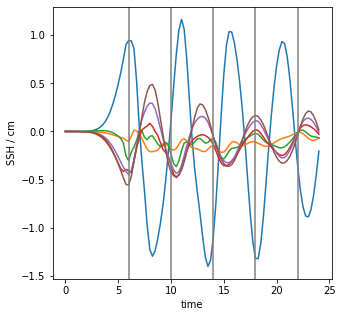

In [129]:
fig, (ax1) = plt.subplots(1,1, figsize=(5,5), sharey=True,sharex=True)

with Dataset(state_file1, 'r') as nbl:
    eta1 = nbl.variables['Eta'][:,lat_ind1,-10]
    time = nbl.variables['T'][:]
    eta2 = nbl.variables['Eta'][:,lat_ind2,-115]
    eta3 = nbl.variables['Eta'][:,lat_ind2+50,-135]
    eta4 = nbl.variables['Eta'][:,lat_ind2+100,-165]
    eta5 = nbl.variables['Eta'][:,lat_ind2+150,-190]
    eta6 = nbl.variables['Eta'][:,lat_ind2+200,-215]

ax1.plot(time/3600,(eta1)*100 )
ax1.plot(time/3600,(eta2)*100 )
ax1.plot(time/3600,(eta3)*100 )
ax1.plot(time/3600,(eta4)*100 )
ax1.plot(time/3600,(eta5)*100 )
ax1.plot(time/3600,(eta6)*100 )

for ii in range(5):
    ax1.axvline(6+(4*ii), color='0.5')
ax1.set_ylabel('SSH / cm')
ax1.set_xlabel('time')

#ax1.set_xlim(0,60)



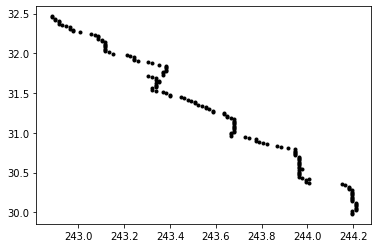

In [72]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(12,3), sharey=True,sharex=True)
ax1.axhline(5.5, color='k', linestyle='--')
ax2.axhline(5.5, color='k', linestyle='--')
ax3.axhline(5.5, color='k', linestyle='--')
ax4.axhline(5.5, color='k', linestyle='--')

with Dataset(state_file1, 'r') as nbl:
    eta1 = nbl.variables['Eta'][:,lat_ind1,:]
    time = nbl.variables['T'][:]
with Dataset(state_file1, 'r') as nbl:
    eta2 = nbl.variables['Eta'][:,lat_ind2,:]
with Dataset(state_file1, 'r') as nbl:
    eta3 = nbl.variables['Eta'][:,lat_ind2+50,:]
with Dataset(state_file1, 'r') as nbl:
    eta4 = nbl.variables['Eta'][:,lat_ind2+100,:]

ax1.pcolormesh(lon,time/3600,(eta1)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax2.pcolormesh(lon,time/3600,(eta2)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax3.pcolormesh(lon,time/3600,(eta3)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax4.pcolormesh(lon,time/3600,(eta4)*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)

ax1.set_title('SSH / cm')
ax1.set_ylabel('time')
ax1.set_xlabel('lon')
ax2.set_xlabel('lon')

#ax1.set_xlim(0,60)



ValueError: too many values to unpack (expected 2)

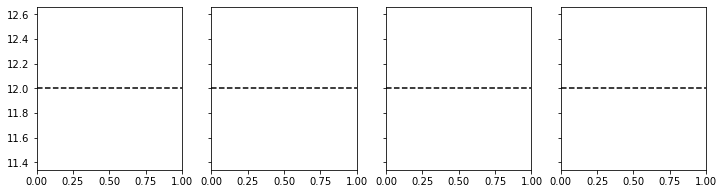

In [73]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(12,3), sharey=True,sharex=True)
ax1.axhline(12, color='k', linestyle='--')
ax2.axhline(12, color='k', linestyle='--')
ax3.axhline(12, color='k', linestyle='--')
ax4.axhline(12, color='k', linestyle='--')

with Dataset(state_file1, 'r') as nbl:
    eta1 = nbl.variables['Eta'][:,coast_lat_ind,coast_lon_ind]
    time = nbl.variables['T'][:]
with Dataset(state_file1, 'r') as nbl:
    eta2 = nbl.variables['Eta'][:,coast_lat_ind,coast_lon_ind]
with Dataset(state_file1, 'r') as nbl:
    eta3 = nbl.variables['Eta'][:,coast_lat_ind,coast_lon_ind]
with Dataset(state_file1, 'r') as nbl:
    eta4 = nbl.variables['Eta'][:,coast_lat_ind,coast_lon_ind]

ax1.pcolormesh(lon,time/3600,(eta1-eta1[12,:])*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax2.pcolormesh(lon,time/3600,(eta2-eta2[12,:])*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax3.pcolormesh(lon,time/3600,(eta3-eta3[12,:])*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)
ax4.pcolormesh(lon,time/3600,(eta4-eta4[12,:])*100,cmap=cmo.cm.balance,vmin=-0.5, vmax=0.5)

ax1.set_title('SSH / cm')
ax1.set_ylabel('time')
ax1.set_xlabel('lon')
ax2.set_xlabel('lon')

In [95]:
time[22]/3600

5.5